In [17]:
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
import numpy as np
import statsmodels
import numpy.linalg as la
import matplotlib.pyplot as plt
import btbpy as btb

In [2]:
def orthogonalize(U, eps=1e-15):
    """
    from https://gist.github.com/anmolkabra/b95b8e7fb7a6ff12ba5d120b6d9d1937
    """
    n = len(U[0])
    V = U.T
    for i in range(n):
        prev_basis = V[0:i]     # orthonormal basis before V[i]
        coeff_vec = np.dot(prev_basis, V[i].T)  # each entry is np.dot(V[j], V[i]) for all j < i 
        V[i] -= np.dot(coeff_vec, prev_basis).T
        if la.norm(V[i]) < eps:
            V[i][V[i] < eps] = 0.   # set the small entries to 0
        else:
            V[i] /= la.norm(V[i])
    return V.T

In [3]:
points_c = pd.read_parquet('coord_france_indif_indus_remar_concentrated.parquet.gzip')

In [4]:
points_d = pd.read_parquet('coord_france_indif_indus_remar_dispersed.parquet.gzip')

<Axes: xlabel='x', ylabel='y'>

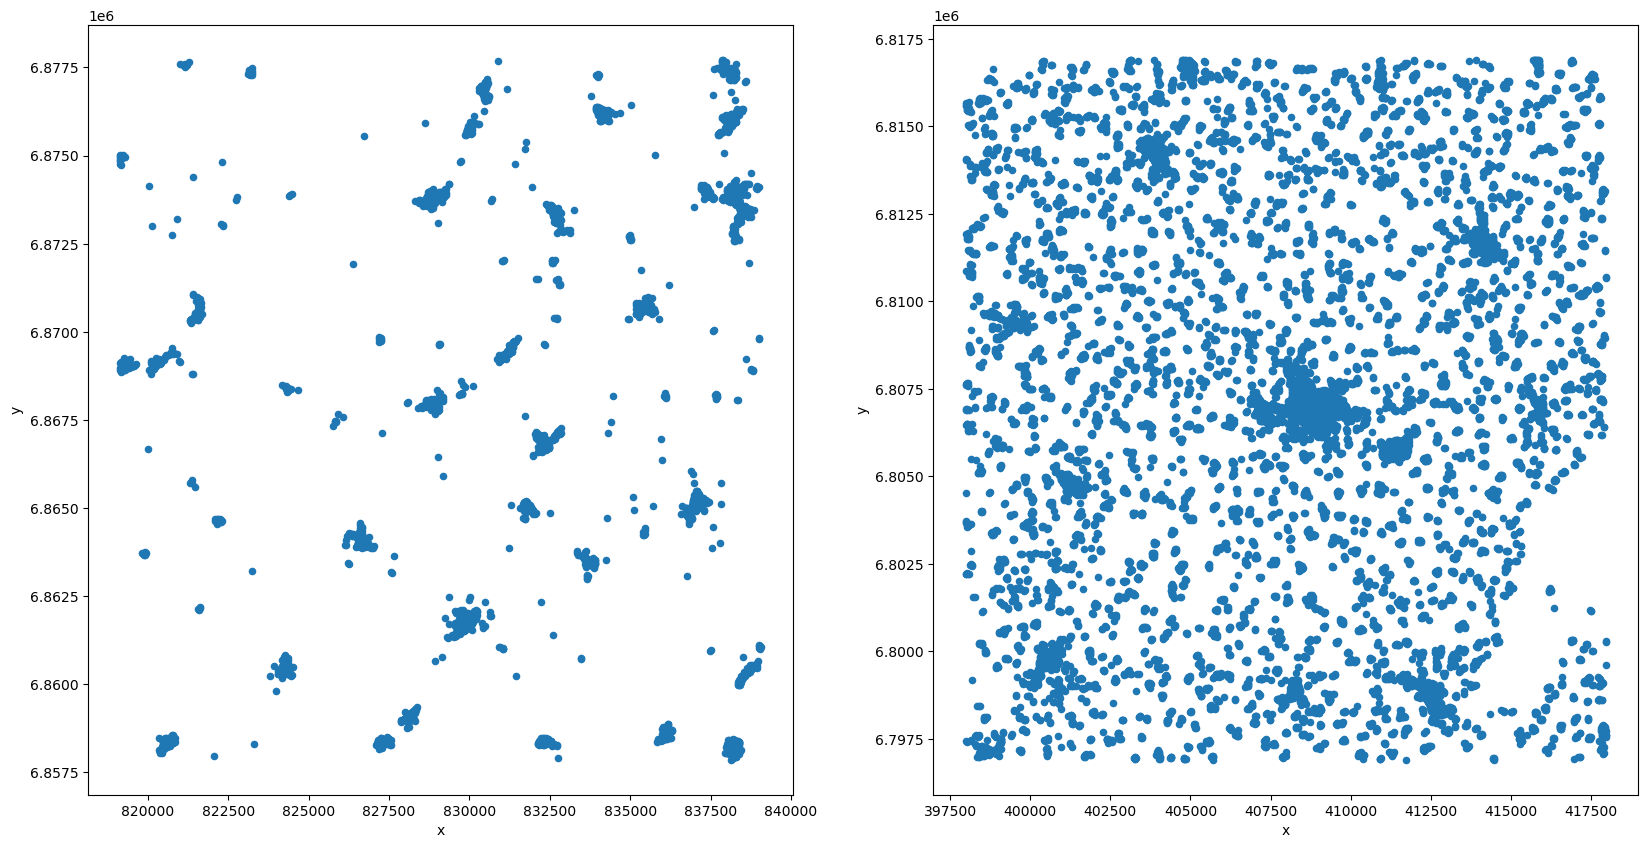

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
points_c.plot.scatter('x','y', ax=ax1)
points_d.plot.scatter('x','y', ax=ax2)

Nos rayons

In [6]:
radius=np.array([50,100,200,400,800])

On calcule le nombre de voisins puis l'inverse pour estimer par la méthode de sandbox la dimension de boxcounting

In [ ]:
neighbors=np.zeros((points_c.shape[0],radius.size),dtype=float)
tree = KDTree(points_c)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(points_c,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([points_c,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_c=pd.DataFrame(output,columns=names)


sdbc_c = (output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1).sum(0)**-1

In [ ]:
neighbors=np.zeros((points_d.shape[0],radius.size),dtype=float)
tree = KDTree(points_d)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(points_d,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([points_d,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_d=pd.DataFrame(output,columns=names)


sdbc_d = (output_d[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1).sum(0)**-1

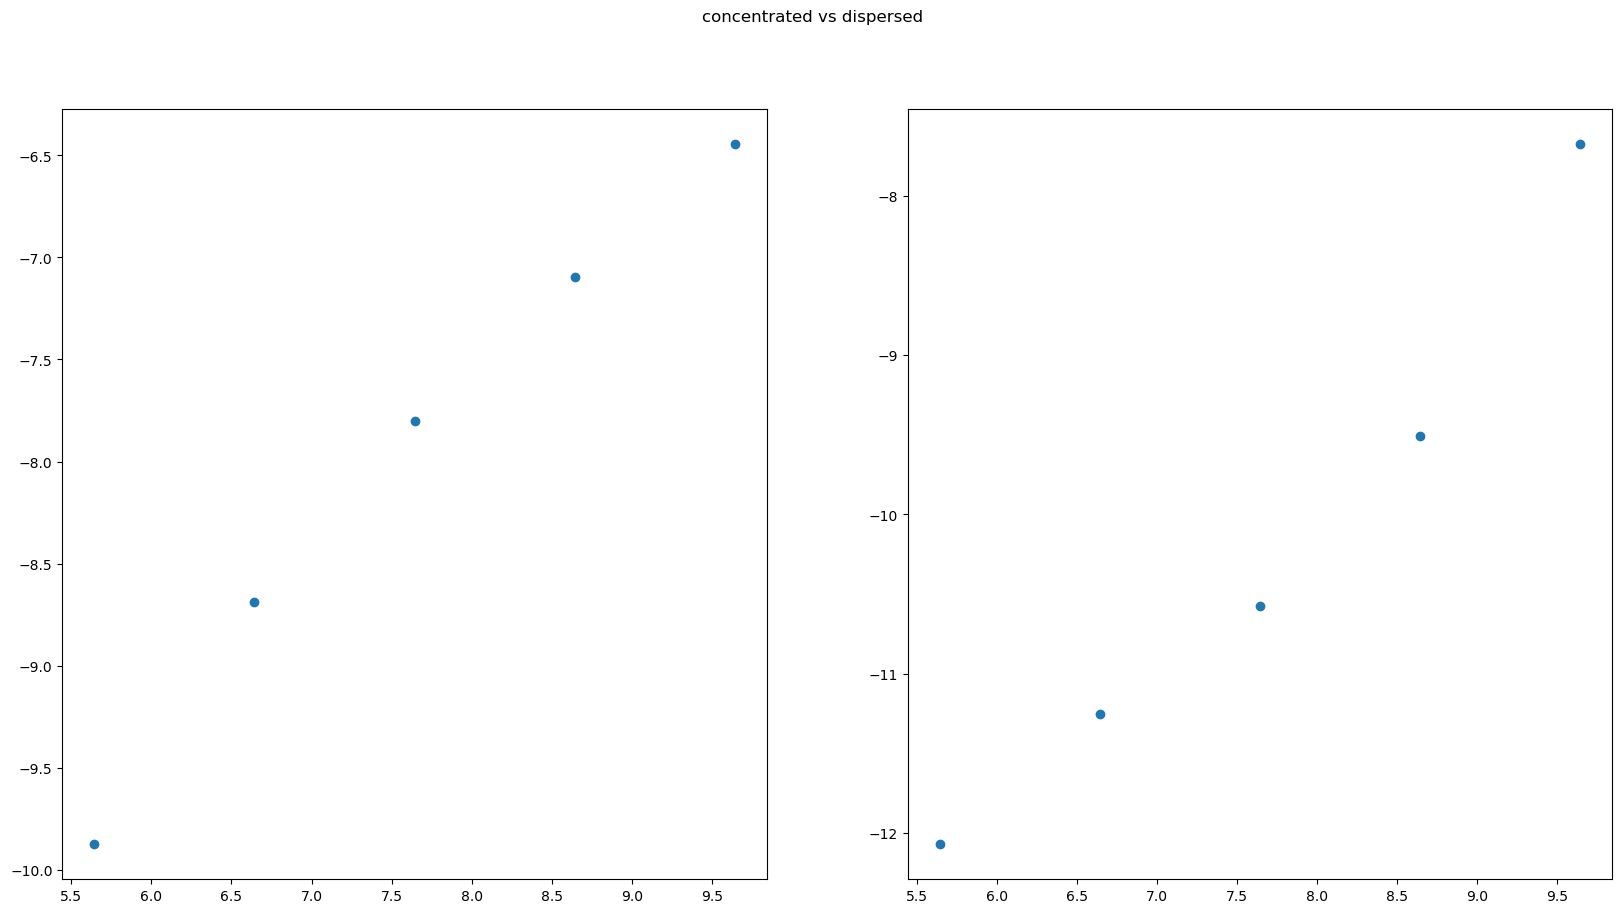

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('concentrated vs dispersed')
ax1.scatter(np.log2(radius), np.log2(sdbc_c))
ax2.scatter(np.log2(radius), np.log2(sdbc_d))

On obtient par cette régression les coeffs,a0, a1 et a2 de a0 + a1 * log(s) + a2 * log(s)^2. Comme les polygones sont normalisés a1 n'est pas directement la dimension fractale mais est a1=k*D. a2 est l'écart à l'invariance d'échelle.

In [11]:
poly2 = orthogonalize(np.concatenate([np.ones(len(radius)), np.log2(radius), np.log2(radius)**2]).reshape(3,len(radius)).T)

In [12]:
np.matmul(np.log2(sdbc_c), poly2)

array([-17.84468604,   2.67170571,  -0.33714737])

In [13]:
np.matmul(np.log2(sdbc_d), poly2)

array([-22.84596688,   3.33290428,   0.64754409])

On fait à présent le calcul sur le Calvados élargi avec la gwfa

In [15]:
calvados = pd.read_parquet('coord_calvados_indif_indus_remar.parquet.gzip')

In [ ]:
neighbors=np.zeros((calvados.shape[0],radius.size),dtype=float)
tree = KDTree(calvados)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(calvados,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([calvados,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_c=pd.DataFrame(output,columns=names)

In [18]:
output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']] = output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1

In [43]:
lissage = btb.kernelSmoothing(output_c, '2154', 1000, 8000)

-------------------------------------------------
number of asked cores : 1
-------------------------------------------------
start of smoothing loop
-------------------------------------------------
-------------------------------------------------
end of smoothing loop - duration time in seconds = 4.609269857406616
-------------------------------------------------
-------------------------------------------------
start of the final grid map cooking
-------------------------------------------------
	-------------------------------------------------
	start of making polygons
	-------------------------------------------------
	-------------------------------------------------
	end of making polygons - duration in seconds = 0.6473252773284912
	-------------------------------------------------
	start of saving geodataframe
	-------------------------------------------------
	-------------------------------------------------
	end of saving geodataframe - duration in seconds = 0.005811691284

/opt/conda/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [44]:
multiscale = -np.matmul(np.log2(lissage[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]), poly2)
multiscale.columns= ['a0', 'a1', 'a2']

In [45]:
lissage = pd.concat([lissage, multiscale], axis=1)

<Axes: >

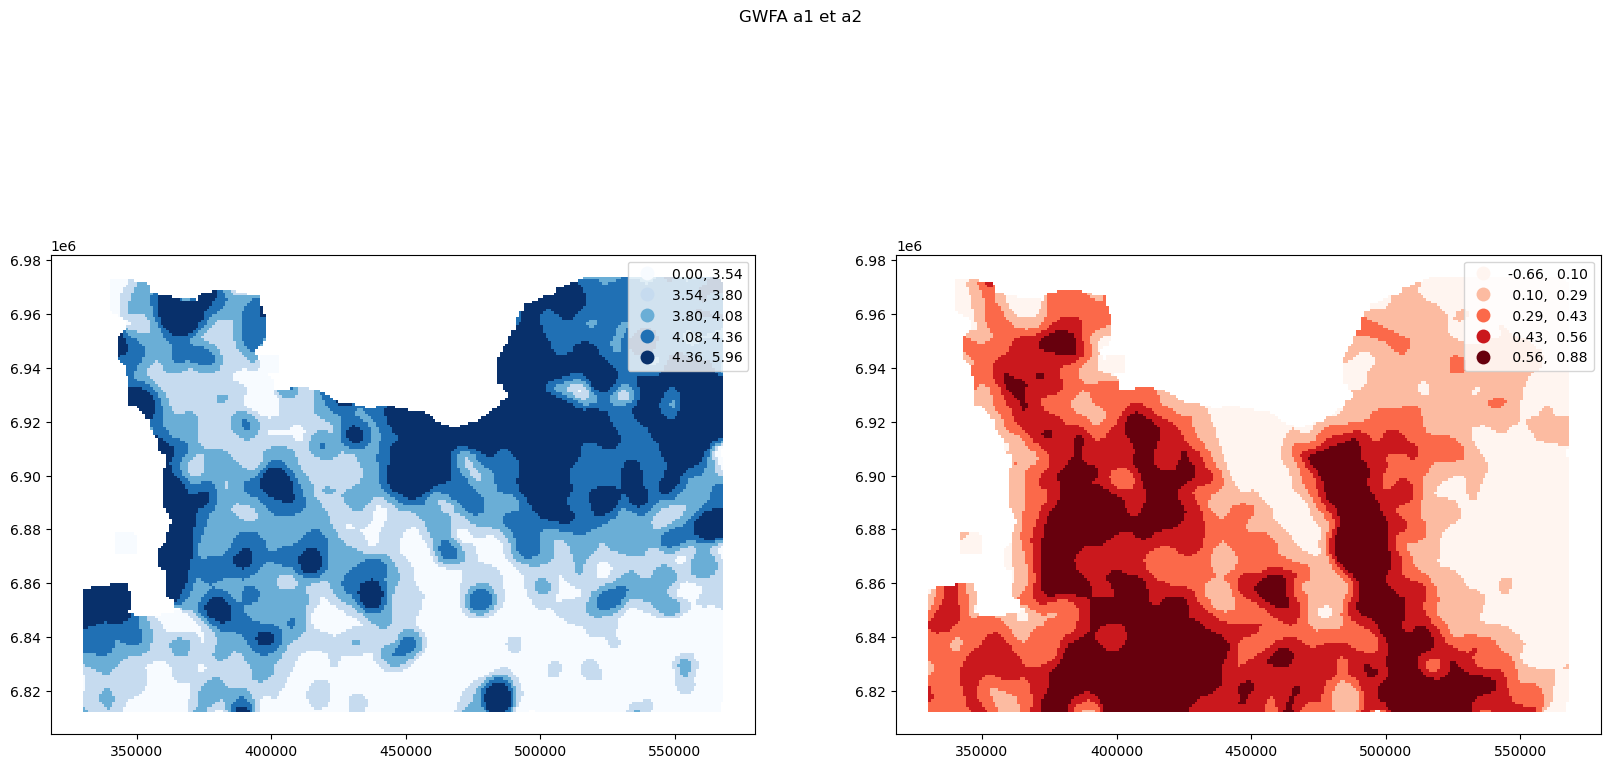

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('GWFA a1 et a2')
lissage.plot('a1', scheme='quantiles',  legend=True, ax=ax1, cmap='Blues')
lissage.plot('a2', scheme='quantiles',  legend=True, ax=ax2, cmap='Reds')